<a href="https://colab.research.google.com/github/payalporwal/depression-detection/blob/main/Bi_GRU-BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U "tensorflow==2.9.*" --quiet
!pip install tensorflow-gpu --quiet
#!pip install -U "tensorflow-text==2.9.*" --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 108.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
#import tensorflow_text as tf_text
import pandas as pd
from keras import layers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, MaxPooling1D, Input, GlobalAveragePooling1D, GRU
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, roc_curve, auc
import numpy as np
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk import PorterStemmer
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model
import seaborn as sns
from nltk.tokenize import WordPunctTokenizer
from pprint import pprint
from bs4 import BeautifulSoup

In [ ]:
df = pd.read_csv('depression_detection.csv')
df

,text,label
0,Open discussion. Between the Transfer Portal a...,1
1,Plenty of things are changing in my life and t...,1
2,I feel a little hopeless. Anyone else? #hopele...,1
3,"Which is more healthy? Hope, or hopelessness? ...",1
4,So someone tell me how do I get over #HOPELESS...,1
...,...,...
39137,"@andreaj27 well, cheers. i have a glass of wat...",0
39138,@AndreaJo84 Is that right? You're over in Palm...,0
39139,@AndreaKobayashi It's the best cafe in Asakusa...,0
39140,@AndreaKoeln heeey! tonight is the night! no s...,0


In [ ]:
df.label.value_counts()

0    20952
1    18190
Name: label, dtype: int64

In [ ]:
df['pre_clean_len'] = [len(t) for t in df.text]
df

,text,label,pre_clean_len
0,Open discussion. Between the Transfer Portal a...,1,193
1,Plenty of things are changing in my life and t...,1,132
2,I feel a little hopeless. Anyone else? #hopele...,1,52
3,"Which is more healthy? Hope, or hopelessness? ...",1,79
4,So someone tell me how do I get over #HOPELESS...,1,274
...,...,...,...
39137,"@andreaj27 well, cheers. i have a glass of wat...",0,84
39138,@AndreaJo84 Is that right? You're over in Palm...,0,138
39139,@AndreaKobayashi It's the best cafe in Asakusa...,0,93
39140,@AndreaKoeln heeey! tonight is the night! no s...,0,86


In [ ]:
data_dict = {
    'label':{
        'type':df.label.dtype,
        'description':'class - 0: non-depressed , 1: depressed'
    },
    'text':{
        'type':df.text.dtype,
        'description':'tweet text'
    },
    'pre_clean_len':{
        'type':df.pre_clean_len.dtype,
        'description':'Length of the tweet before cleaning'
    },
    'dataset_shape':df.shape
}
pprint(data_dict)

{'dataset_shape': (39142, 3),
 'label': {'description': 'class - 0: non-depressed , 1: depressed',
           'type': dtype('int64')},
 'pre_clean_len': {'description': 'Length of the tweet before cleaning',
                   'type': dtype('int64')},
 'text': {'description': 'tweet text', 'type': dtype('O')}}


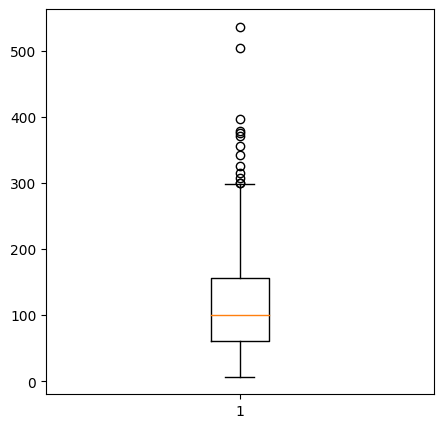

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

In [ ]:
df[df.pre_clean_len > 160].count()

text             9495
label            9495
pre_clean_len    9495
dtype: int64

In [ ]:
df[df.pre_clean_len > 160].head(10)

,text,label,pre_clean_len
0,Open discussion. Between the Transfer Portal a...,1,193
4,So someone tell me how do I get over #HOPELESS...,1,274
7,I am so glad that @GreysABC is tackling the hu...,1,278
8,If you know someone who’s depressed please res...,1,272
9,A #grateful #heart will #SeeGod. You will find...,1,260
10,“Our world today so desperately hungers for ho...,1,255
11,Depression is a bitch that is difficult for me...,1,222
12,Add to this list #whatsincreased \n#petrol\n#d...,1,279
14,"“Go if you have to, but remember, don’t come b...",1,220
15,"Hey @Headspace, I need to believe in something...",1,231


In [ ]:
df.text[385]

'I wish I was enough\n\n#heartbroken #love #cheating #stupid #Choices #Alone #Broken #Sad #hurt #breakup #stress #depressed #relationships'

In [ ]:
example1 = BeautifulSoup(df.text[13385], 'lxml')
print(example1.get_text())

Remember anti depressants have side effects that include super surreal dreams that make you think you're awake and it all actually happened... cuz damn... in fucked up rn. #depression


In [ ]:
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+' # handle twitter id's
pat2 = r'https?://[^ ]+' # handle urls starting with https
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'   # handle urls starting with www
# Negations are separated due to the use of tokenizer.
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)

    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()


nums = [0, 39142]
print("Cleaning and parsing the tweets...\n")
clean_tweet_texts = ''
for i in range(nums[1]):
    if((i+1) % 10000 == 0):
        print("Tweets %d of %d has been processed" % (i + 1, nums[1]))
    clean_tweet_texts += (tweet_cleaner_updated(df['text'][i]))



Cleaning and parsing the tweets...



<ipython-input-4-dd939f723588>:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'lxml')


Tweets 10000 of 39142 has been processed
Tweets 20000 of 39142 has been processed
Tweets 30000 of 39142 has been processed


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

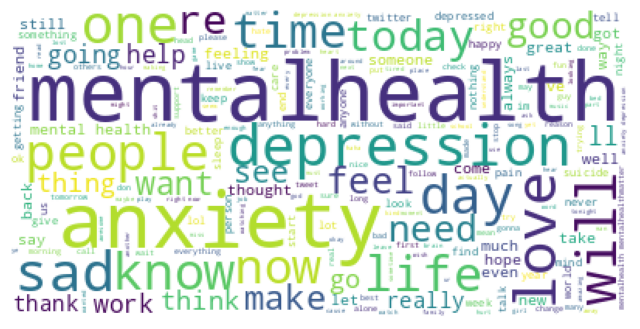

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create the wordcloud object
wordcloud = WordCloud( background_color = 'white').generate(clean_tweet_texts)

# Display the generated image:
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
clean_df = pd.DataFrame(clean_tweet_texts, columns=['text'])
clean_df['category'] = df.label
clean_df

,text,category
0,open discussion between the transfer portal an...,1
1,plenty of things are changing in my life and t...,1
2,feel little hopeless anyone else hopelessness,1
3,which is more healthy hope or hopelessness hop...,1
4,so someone tell me how do get over hopelessnes...,1
...,...,...
39137,well cheers have glass of water handy ll drink...,0
39138,is that right you re over in palm springs gues...,0
39139,it the best cafe in asakusa tokyo very small b...,0
39140,heeey tonight is the night no sleeping like we...,0


In [ ]:
clean_df['pre_clean_len'] = [len(t) for t in clean_df.text]
#clean_df.drop('pre_clean_len', axis=1, inplace=True)
clean_df

,text,category,pre_clean_len
0,open discussion between the transfer portal an...,1,152
1,plenty of things are changing in my life and t...,1,129
2,feel little hopeless anyone else hopelessness,1,45
3,which is more healthy hope or hopelessness hop...,1,73
4,so someone tell me how do get over hopelessnes...,1,250
...,...,...,...
39137,well cheers have glass of water handy ll drink...,0,63
39138,is that right you re over in palm springs gues...,0,120
39139,it the best cafe in asakusa tokyo very small b...,0,71
39140,heeey tonight is the night no sleeping like we...,0,68


In [ ]:
!pip install circlify -- quiet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
encoder = LabelEncoder()
x = clean_df.drop('category', axis=1)
y = clean_df['category']
Y = encoder.fit_transform(y)

In [ ]:
var= x.copy()

In [ ]:
var.reset_index(inplace=True)
var

,index,text,pre_clean_len
0,0,open discussion between the transfer portal an...,152
1,1,plenty of things are changing in my life and t...,129
2,2,feel little hopeless anyone else hopelessness,45
3,3,which is more healthy hope or hopelessness hop...,73
4,4,so someone tell me how do get over hopelessnes...,250
...,...,...,...
39137,39137,well cheers have glass of water handy ll drink...,63
39138,39138,is that right you re over in palm springs gues...,120
39139,39139,it the best cafe in asakusa tokyo very small b...,71
39140,39140,heeey tonight is the night no sleeping like we...,68


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stemmer = PorterStemmer()
corpus = []
for i in range(0, len(var)):
    review = re.sub('[^a-zA-Z]', ' ', var['text'][i])
    review = review.lower()
    review = review.split()

    review = [stemmer.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
#Vocabulary Size
vocab_size=5000
encoding = [one_hot(words,vocab_size) for words in corpus]
emb_docs=pad_sequences(encoding,padding='pre',maxlen=200)
print(emb_docs)

[[   0    0    0 ... 3457 3175 3737]
 [   0    0    0 ...  298 3071 3457]
 [   0    0    0 ... 3777 4850 3457]
 ...
 [   0    0    0 ... 3095 4687 3978]
 [   0    0    0 ... 3395 1348 4374]
 [   0    0    0 ...    0 1904 2561]]


In [ ]:
from sklearn.model_selection import train_test_split
x_final= np.array(emb_docs)
y_final= np.array(y)
x_train,x_test,y_train,y_test=train_test_split(x_final,y_final,test_size=0.2,random_state=0)

In [ ]:
model = Sequential()

n_unique_words = 10000 # cut texts after this number of words
maxlen = 200
batch_size = 128
pool_size= 128
# Neural network layers
model.add(Embedding(n_unique_words, 128, input_length=maxlen))
model.add(Bidirectional(GRU(25, return_sequences=True, dropout=0.25, recurrent_dropout=0.2)))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.1, name="dropout"))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 50)          23250     
 l)                                                              
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 1,303,301
Trainable params: 1,303,301
Non-

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)
history = model.fit(x_train , y_train ,validation_split=0.25, batch_size = 64, epochs = 30, callbacks=[es])

Epoch 1/30
367/367 [==============================] - 615s 2s/step - loss: 0.2499 - accuracy: 0.8630 - val_loss: 0.0233 - val_accuracy: 0.9958
Epoch 2/30
367/367 [==============================] - 609s 2s/step - loss: 0.0225 - accuracy: 0.9957 - val_loss: 0.0188 - val_accuracy: 0.9958
Epoch 3/30
367/367 [==============================] - 607s 2s/step - loss: 0.0204 - accuracy: 0.9960 - val_loss: 0.0212 - val_accuracy: 0.9957
Epoch 4/30
367/367 [==============================] - 599s 2s/step - loss: 0.0159 - accuracy: 0.9966 - val_loss: 0.0187 - val_accuracy: 0.9950
Epoch 5/30
367/367 [==============================] - 598s 2s/step - loss: 0.0131 - accuracy: 0.9970 - val_loss: 0.0202 - val_accuracy: 0.9953
Epoch 6/30
367/367 [==============================] - 604s 2s/step - loss: 0.0100 - accuracy: 0.9977 - val_loss: 0.0191 - val_accuracy: 0.9960
Epoch 7/30
367/367 [==============================] - 604s 2s/step - loss: 0.0075 - accuracy: 0.9988 - val_loss: 0.0300 - val_accuracy: 0.9928

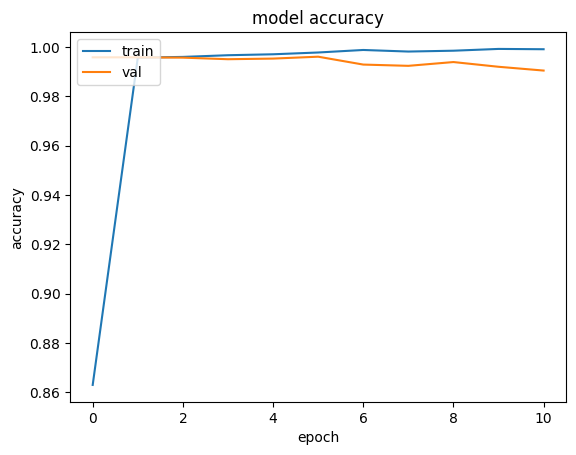

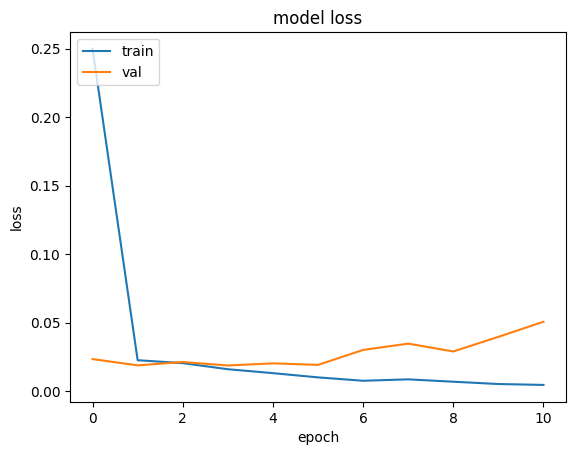

In [ ]:
#accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(x_test, y_test)

245/245 [==============================] - 32s 129ms/step - loss: 0.0184 - accuracy: 0.9958


[0.01836533285677433, 0.9957848787307739]

In [ ]:
y_predicted = model.predict(x_test)
y_predicted = y_predicted.flatten()
y_predicted

245/245 [==============================] - 31s 125ms/step


array([8.28809279e-05, 8.84121182e-05, 9.99186218e-01, ...,
       1.09402645e-04, 9.99520302e-01, 8.60359214e-05], dtype=float32)

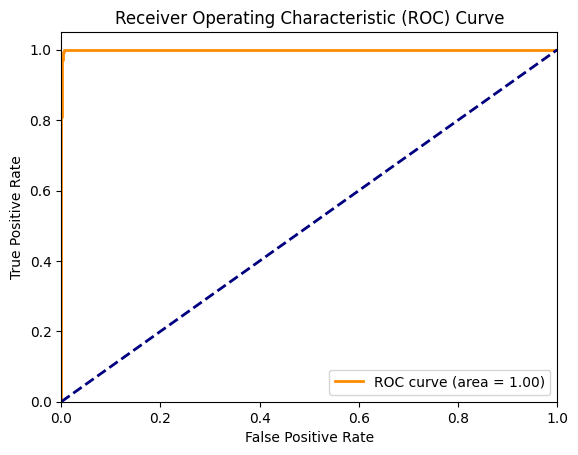

In [ ]:
# Predict probabilities for the test set
# Calculate the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_predicted)

# Calculate the AUC ROC score
roc_auc = auc(fpr, tpr)

# Plot the AUC ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
print(y_test)

[0 0 1 ... 0 1 0]


In [ ]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, ..., 0, 1, 0])

In [ ]:
cf_matrix = confusion_matrix(y_predicted,y_test)
print(cf_matrix)


[[4187    8]
 [  25 3609]]


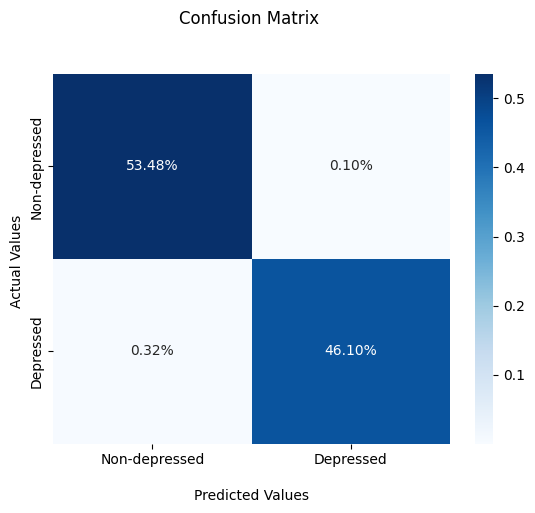

In [ ]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Non-depressed','Depressed'])
ax.yaxis.set_ticklabels(['Non-depressed','Depressed'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
print(accuracy_score(y_predicted,y_test)*100)

99.57849022863712


In [ ]:
print(classification_report(y_predicted,y_test))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4195
           1       1.00      0.99      1.00      3634

    accuracy                           1.00      7829
   macro avg       1.00      1.00      1.00      7829
weighted avg       1.00      1.00      1.00      7829

